In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm, t
from scipy.special import gammaln  # For the log-gamma function (in the loglikelilook of the student-t distribution)
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from scipy.stats import skew, kurtosis

In [2]:
# Load our clean data
data = pd.read_csv("data_clean.csv").drop(columns=["Unnamed: 0"]).set_index("day_tick")

In [3]:
import warnings
warnings.filterwarnings("ignore")

First of all, we resample our data to be daily (explain maybe a little bit that GARCH models perform better in daily data than HF data, cite some paper)

<AxesSubplot: xlabel='day'>

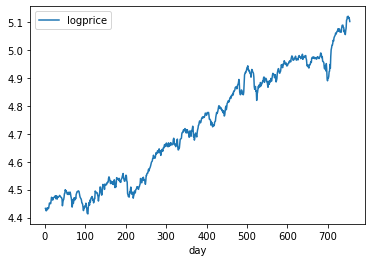

In [4]:
daily_data = data.groupby("day").last()
daily_data["log_returns"] = (daily_data["logprice"] - daily_data["logprice"].shift(1))
daily_data = daily_data.dropna()
daily_data[["logprice"]].plot()

$$
\log L^c(\theta) = -\frac{1}{2} \sum_{t=q+1}^{n} \left( 
    \log(2 \pi) + \log(\sigma_t^2) 
    + \frac{\epsilon_t^2}{\sigma_t^2} 
\right)
$$


In [5]:
returns = daily_data['log_returns'].dropna().values

In [6]:
# Extract the Log Returns
y = daily_data['log_returns'].values
n = len(y)

# Define the Conditional Variance Function
def conditional_variance(params, y, mu):

    omega, alpha, beta = params
    sigma2 = np.zeros_like(y)
    sigma2[0] = np.var(y)  # Set the first element to be the variance of our returns (sample variance)

    for t in range(1, len(y)):
        sigma2[t] = omega + alpha * (y[t-1] - mu)**2 + beta * sigma2[t-1]

    return sigma2


# Define the Negative Log-Likelihood Function
def neg_log_likelihood(params, y, mu):

    omega, alpha, beta = params

    # Parameter constraints (infinite penalty)
    if omega <= 0 or alpha < 0 or beta < 0 or (alpha + beta) >= 1:
        return np.inf

    sigma2 = conditional_variance(params, y, mu)

    # Avoid division by zero or log of zero
    if np.any(sigma2 <= 0):
        return np.inf

    # Log-likelihood assuming normal distribution of residuals (residuals = y - mu)
    ll = -0.5 * (np.log(2 * np.pi) + np.log(sigma2) + ((y - mu)**2) / sigma2)
    
    return -np.sum(ll)  # Negative log-likelihood


# Initial Parameter Guesses
mu = returns.mean()
initial_omega = 1e-5
initial_alpha = 0.1
initial_beta = 0.8
initial_params = [initial_omega, initial_alpha, initial_beta]

# Define Bounds and Constraints
bounds = [(1e-8, None), (0, 1), (0, 1)]  # omega >0, alpha and beta between 0 and1

# Constraint: alpha + beta < 1 for stationarity
constraints = ({
    'type': 'ineq',
    'fun': lambda x: 1 - x[1] - x[2]  # 1 - alpha - beta > 0
})

# Optimize the Parameters
result = minimize(
    neg_log_likelihood,
    initial_params,
    args=(y, mu),
    method='L-BFGS-B',
    bounds=bounds,
    constraints=constraints
)

# Save the results into our variables
fitted_params = result.x
omega_est, alpha_est, beta_est = fitted_params
mu_est = mu


# Show the Results
print("GARCH(1,1) Model Fit Summary")
print("----------------------------")
print(f"mu           : {mu:.6f}")
print(f"omega        : {omega_est:.6f}")
print(f"alpha        : {alpha_est:.6f}")
print(f"beta         : {beta_est:.6f}")
print(f"alpha + beta : {alpha_est + beta_est:.6f}")


GARCH(1,1) Model Fit Summary
----------------------------
mu           : 0.000900
omega        : 0.000009
alpha        : 0.098934
beta         : 0.791474
alpha + beta : 0.890408


In [7]:
# Compute the fitted conditional variances
sigma2_fitted = conditional_variance(fitted_params, y, mu)
sigma_fitted = np.sqrt(sigma2_fitted)


In [8]:
returns = np.array(returns) 

# Fit the Student's t-distribution to estimate the degrees of freedom
nu_est, loc, scale = t.fit(returns) 
nu_est = int(np.ceil(nu_est))


print(f"Estimated degrees of freedom (ν): {nu_est}")
print(f"Estimated location (mean): {loc}")
print(f"Estimated scale (std deviation): {scale}")

Estimated degrees of freedom (ν): 5
Estimated location (mean): 0.0010096219509849612
Estimated scale (std deviation): 0.006856982490287419


In [ ]:
def conditional_variance_t(params, y, mu):

    omega, alpha, beta = params[:3]
    sigma2 = np.zeros_like(y)
    sigma2[0] = np.var(y)  # Initialize with the variance of the data

    for t in range(1, len(y)):
        sigma2[t] = omega + alpha * (y[t-1] - mu)**2 + beta * sigma2[t-1]

    return sigma2


# Negative Log-Likelihood Function for Student-t
def neg_log_likelihood_t(params, y, mu):

    omega, alpha, beta, nu = params

    # Parameter constraints
    if omega <= 0 or alpha < 0 or beta < 0 or (alpha + beta) >= 1 or nu <= 2:
        return np.inf  # Return a large number to penalize invalid parameters

    # Compute conditional variance
    sigma2 = conditional_variance_t(params, y, mu)

    # Avoid division by zero or log of zero
    if np.any(sigma2 <= 0):
        return np.inf

    # Compute the log-likelihood for Student-t distribution (using the log-gamma function)
    ll = gammaln((nu + 1) / 2) - gammaln(nu / 2) - 0.5 * np.log(nu * np.pi * sigma2) - ((nu + 1) / 2) * np.log(1 + ((y - mu)**2) / (nu * sigma2))
    
    return -np.sum(ll)  # Negative log-likelihood


# Initial Parameter Guesses
mu_t = y.mean()
initial_omega_t = 1e-5
initial_alpha_t = 0.1
initial_beta_t = 0.8
initial_nu_t = nu_est

initial_params_t = [initial_omega_t, initial_alpha_t, initial_beta_t, initial_nu_t]


# Define bounds for the parameters:
bounds_t = [
    (1e-8, None),   # omega > 0
    (0, 1),         # alpha between 0 and 1
    (0, 1),         # beta between 0 and 1
    (2.1, 100)      # nu > 2 to ensure finite variance, upper bound to prevent excessive values
]

# Constraint: alpha + beta < 1 for stationarity
constraints_t = ({
    'type': 'ineq',
    'fun': lambda x: 1 - x[1] - x[2]  # 1 - alpha - beta > 0
})


# Optimize the parameters using the L-BFGS-B method, which handles bounds well
result_t = minimize(
    neg_log_likelihood_t,
    initial_params_t,
    args=(y, mu_t),
    method='L-BFGS-B',
    bounds=bounds_t,
    constraints=constraints_t,
    options={'disp': True, 'maxiter': 10000}
)


# Extract the fitted parameters
fitted_params_t = result_t.x
omega_est_t, alpha_est_t, beta_est_t, _ = fitted_params_t
mu_est_t = mu  # Mean remains the same


# Compute the fitted conditional variances
sigma2_fitted_t = conditional_variance_t(fitted_params_t, y, mu_est_t)
sigma_fitted_t = np.sqrt(sigma2_fitted_t)

print("GARCH(1,1) Model Fit Summary with Student-t Distribution")
print("--------------------------------------------------------")
print(f"mu           : {mu_est_t:.6f}")
print(f"omega        : {omega_est_t:.6f}")
print(f"alpha        : {alpha_est_t:.6f}")
print(f"beta         : {beta_est_t:.6f}")
print(f"alpha + beta : {alpha_est_t + beta_est_t:.6f}")

GARCH(1,1) Model Fit Summary with Student-t Distribution
--------------------------------------------------------
mu           : 0.000900
omega        : 0.000007
alpha        : 0.068377
beta         : 0.757318
alpha + beta : 0.825695


## GARCH Comparison

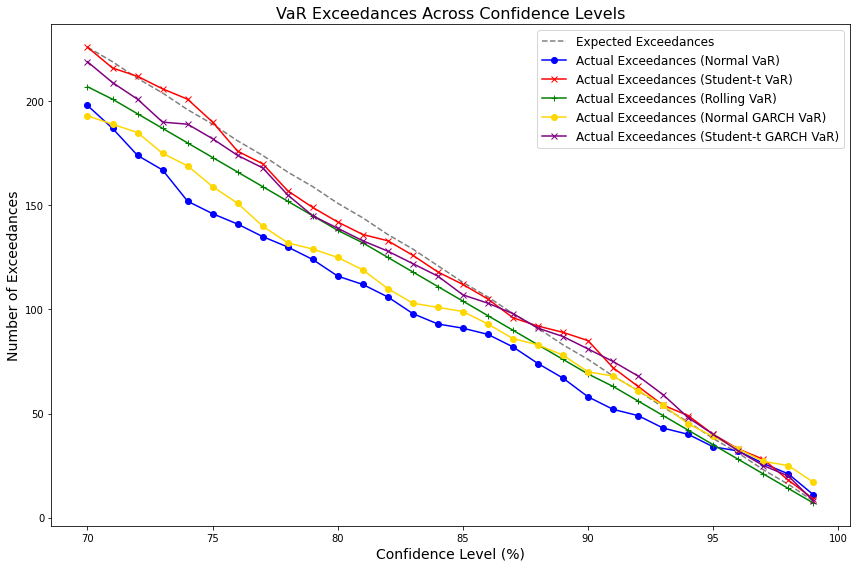

In [ ]:
# Define a range of confidence levels from 90% to 99%
confidence_levels = np.arange(0.70, 0.999, 0.01)  # 90% to 99.5% in steps of 0.5%

# Initialize lists to store exceedance counts
exceedances_normal = []
exceedances_t = []
expected_exceedances = []
exceedances_empirical = [] # Initialize as a list
exceedances_rolling = [] # Initialize as a list
exceedances_normal_garch = []
exceedances_t_garch = []

window = 63
daily_returns = daily_data["log_returns"]
rolling_mean = daily_returns.rolling(window=window).mean()
rolling_volatility = daily_returns.rolling(window=window).std()
standardized_returns = (daily_returns - rolling_mean) / rolling_volatility
standardized_returns_non_nan = standardized_returns.dropna()
mean_returns = daily_returns.mean()
std_dev_returns = daily_returns.std()


# Calculate Exceedances Across Confidence Levels

for cl in confidence_levels:
    # Calculate quantiles
    z_score = norm.ppf(1 - cl)  # Normal quantile
    t_score = t.ppf(1 - cl, df=nu_est)  # Student-t quantile

    VaR_t = t.ppf(1- cl, nu_est, loc=loc, scale=scale)
    Var_empirical=np.percentile(daily_returns, 100 * (1 - cl))
    var_empirical_standardized = np.percentile(standardized_returns_non_nan, 100 * (1 - cl))
    rolling_var= var_empirical_standardized * rolling_volatility + rolling_mean
    var_normal= mean_returns + z_score * std_dev_returns
    VaR_normal_garch = mu_est + z_score * sigma_fitted
    VaR_t_garch = mu_est_t + t_score * sigma_fitted_t

    # Count exceedances
    exceed_normal = np.sum(daily_returns < var_normal)
    exceed_t = np.sum(daily_returns < VaR_t)
    exceed_empirical = np.sum(daily_returns < Var_empirical)
    exceed_rolling = np.sum(daily_returns < rolling_var)
    exceed_normal_garch = np.sum(returns < VaR_normal_garch)
    exceed_t_garch = np.sum(returns < VaR_t_garch)


    # Expected exceedances
    expected_exceed = np.ceil((1 - cl) * len(daily_returns))

    # Append to lists
    exceedances_normal.append(exceed_normal)
    exceedances_t.append(exceed_t)
    exceedances_empirical.append(exceed_empirical) # Append to the list
    exceedances_rolling.append(exceed_rolling) # Append to the list
    expected_exceedances.append(expected_exceed)
    exceedances_normal_garch.append(exceed_normal_garch)
    exceedances_t_garch.append(exceed_t_garch)

# Convert lists to NumPy arrays for easier handling
exceedances_normal = np.array(exceedances_normal)
exceedances_t = np.array(exceedances_t)
exceedances_empirical = np.array(exceedances_empirical)
exceedances_rolling = np.array(exceedances_rolling)
expected_exceedances = np.array(expected_exceedances)
exceedances_normal_garch = np.array(exceedances_normal_garch)
exceedances_t_garch = np.array(exceedances_t_garch)


plt.figure(figsize=(12, 8))

# Plot expected exceedances
plt.plot(confidence_levels * 100, expected_exceedances, label='Expected Exceedances', color='grey', linestyle='--')

# Plot actual exceedances for Normal VaR
plt.plot(confidence_levels * 100, exceedances_normal, label='Actual Exceedances (Normal VaR)', color='blue', marker='o')

# Plot actual exceedances for Student-t VaR
plt.plot(confidence_levels * 100, exceedances_t, label='Actual Exceedances (Student-t VaR)', color='red', marker='x')

# Plot actual exceedances for rolling VaR
plt.plot(confidence_levels * 100, exceedances_rolling, label='Actual Exceedances (Rolling VaR)', color='green', marker='+')

# Plot actual exceedances for Normal GARCH VaR
plt.plot(confidence_levels * 100, exceedances_normal_garch, label='Actual Exceedances (Normal GARCH VaR)', color='gold', marker='o')

# Plot actual exceedances for Student-t GARCH VaR
plt.plot(confidence_levels * 100, exceedances_t_garch, label='Actual Exceedances (Student-t GARCH VaR)', color='purple', marker='x')



# Enhancements
plt.xlabel('Confidence Level (%)', fontsize=14)
plt.ylabel('Number of Exceedances', fontsize=14)
plt.title('VaR Exceedances Across Confidence Levels', fontsize=16)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


# summary_df = pd.DataFrame({
#     'Confidence Level (%)': confidence_levels * 100,
#     'Expected Exceedances': expected_exceedances.astype(int),
#     'Actual Exceedances (Normal)': exceedances_normal,
#     'Actual Exceedances (Student-t)': exceedances_t,
#     'Actual Exceedances (GARCH Normal)': exceedances_normal_garch,
#     'Actual Exceedances (GARCH Student-t)': exceedances_t_garch,
# })



TODO:
 - Compute metric to compare each plot (RMSE, etc...)

## 7th Step: Conclusions? Improvements?

The student-t distribution is the best one because we are computing the measure error on our training set (all the data has been used to describe the distribution and to fit to the GARCH data). One improvement here would be to leave some part of the data apart in the training, and then test our models on this new data (exactly the same as what we do in Machine Learning with the train-test split)